In [10]:
import numpy as np
import astropy.io.fits as fits
import astropy.units as u
from IPython.display import clear_output
import time
from pathlib import Path

import proper
# proper.prop_use_fftw()
# proper.prop_fftw_wisdom( 2048 ) 

import roman_phasec_proper
roman_phasec_proper.copy_here()

import misc
from matplotlib.patches import Circle

# data_dir = Path('C:/Users/Kian/Documents/data-files/disk-processing')
# data_dir = Path('/users/kianmilani/Documents/data-files/disk-processing')
data_dir = Path('/groups/douglase/kians-data-files/disk-processing')

wavelength_c = 575e-9*u.m
D = 2.3631*u.m
mas_per_lamD = (wavelength_c/D*u.radian).to(u.mas)

pixelscale_m_ref = 13e-6*u.m/u.pixel
pixelscale_lamD_ref = 1/2
wavelength_ref = 0.5e-6*u.m

# define desired PSF dimensions and pixelscale in units of lambda/D
npsf = 256                   # output image dimension (must be power of 2)
psf_pixelscale_lamD = 0.1    # output sampling in lam0/D
psf_pixelscale_mas = psf_pixelscale_lamD*mas_per_lamD/u.pix

# define the offsets in lambda/D for which the PSFs will be created
start = 0
stop = 11
step = 0.05
offsets_lamD = np.arange(start,stop+step,step)
print(len(offsets_lamD))

# Define the polarization axis you want to create the psfs for
#    -2 = -45d in, Y out 
#    -1 = -45d in, X out 
#     1 = +45d in, X out 
#     2 = +45d in, Y out 
#     5 = mean of modes -1 & +1 (X channel polarizer)
#     6 = mean of modes -2 & +2 (Y channel polarizer)
#    10 = mean of all modes (no polarization filtering)
polaxis = 1


221


Lambda = 5.7500E-07   Throughput = 1.00
Applying lens
Propagating to secondary
Applying lens
Propagating to POMA FOLD
Propagating to M3
Applying lens
Propagating to M4
Applying lens
Propagating to M5
Applying lens
Propagating to TT FOLD
Propagating to FSM
Propagating to OAP1
Applying lens
Propagating to FOCM
Propagating to OAP2
Applying lens
Propagating to DM1
Propagating to DM2
Propagating to OAP3
Applying lens
Propagating to FOLD_3
Propagating to OAP4
Applying lens
Propagating to PUPIL_MASK
Propagating to OAP5
Applying lens
Propagating to FPM
Propagating to OAP6
Applying lens
Propagating to LYOT STOP
Propagating to OAP7
Applying lens
Propagating to FIELD_STOP
Propagating to OAP8
Applying lens
Propagating to filter
Propagating to IMAGING LENS
Applying lens at IMAGING LENS lens #1
Propagating
Applying lens at IMAGING LENS lens #2
Propagating to IMAGE
Total elapsed time (seconds) =  15.6258


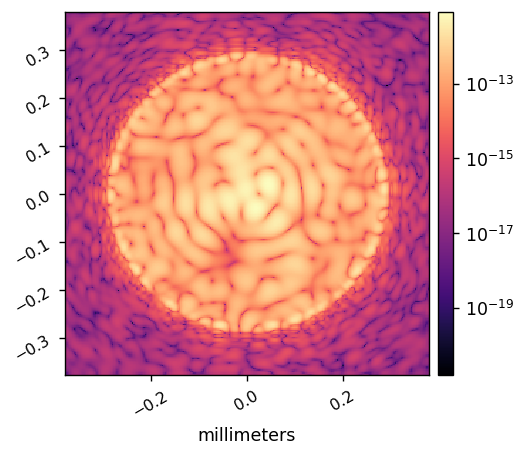

In [11]:
nlam = 1
lam0 = 0.575
if nlam==1:
    lam_array = np.array([lam0])
else:
    bandwidth = 0.1
    minlam = lam0 * (1 - bandwidth/2)
    maxlam = lam0 * (1 + bandwidth/2)
    lam_array = np.linspace( minlam, maxlam, nlam )

xoffset = 0
use_fpm = 1

use_hlc_dm_patterns = 0
use_errors = 1
use_dm1 = 1
use_dm2 = 1
dm1 = proper.prop_fits_read( roman_phasec_proper.lib_dir + r'/examples/hlc_best_contrast_dm1.fits' )
dm2 = proper.prop_fits_read( roman_phasec_proper.lib_dir + r'/examples/hlc_best_contrast_dm2.fits' )
use_fieldstop = 1
use_pupil_defocus = 1

(wfs, pxscls_m) = proper.prop_run_multi('roman_phasec', lam_array, npsf, QUIET=False, 
                                        PASSVALUE={'cor_type':'hlc', # change coronagraph type to correct band
                                                   'final_sampling_lam0':psf_pixelscale_lamD, 
                                                   'source_x_offset':xoffset,
                                                   'use_fpm':use_fpm,
                                                   'use_hlc_dm_patterns':use_hlc_dm_patterns,
                                                   'use_errors': use_errors,
                                                   'use_dm1':use_dm1, 'dm1_m':dm1, 
                                                   'use_dm2':use_dm2, 'dm2_m':dm2,
                                                   'use_field_stop':use_fieldstop,
                                                   'polaxis':polaxis,
                                                  })

psfs = np.abs(wfs)**2
psf_bb = np.sum(psfs, axis=0)/nlam
psf_pixelscale_m = pxscls_m[0]*u.m/u.pix
misc.myimshow(psf_bb, lognorm=True, pxscl=psf_pixelscale_m.to(u.mm/u.pix))

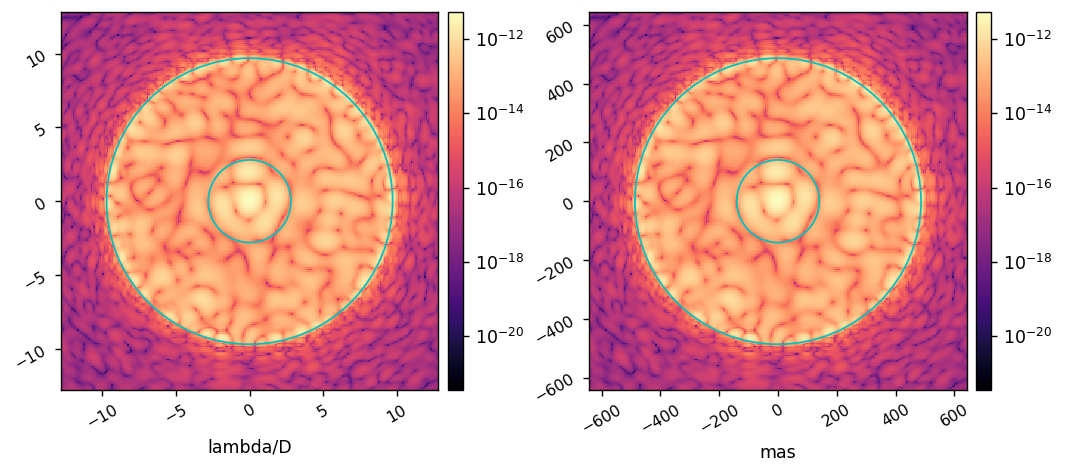

In [9]:
band1_wavelength = 575e-9*u.m
iwa_band1 = 2.8
owa_band1 = 9.7

iwa = iwa_band1 * wavelength_c/band1_wavelength
owa = owa_band1 * wavelength_c/band1_wavelength

iwa_mas = iwa*mas_per_lamD
owa_mas = owa*mas_per_lamD

patches1 = [Circle((0, 0), iwa.value, color='c', fill=False), Circle((0, 0), owa.value, color='c', fill=False)]
patches2 = [Circle((0, 0), iwa_mas.value, color='c', fill=False), Circle((0, 0), owa_mas.value, color='c', fill=False)]
misc.myimshow2(psf_bb, psf_bb, lognorm1=True, lognorm2=True, 
               pxscl1=psf_pixelscale_lamD, pxscl2=psf_pixelscale_mas,
               patches1=patches1, patches2=patches2)

In [9]:
psfs_array = np.zeros(shape=(len(offsets_lamD),npsf,npsf))
start = time.time()
for i, offset_lamD in enumerate(offsets_lamD):
    (wfs, pxscls_m) = proper.prop_run_multi('roman_phasec', lam_array, npsf, QUIET=True, 
                                        PASSVALUE={'cor_type':'hlc_band2',
                                                   'final_sampling_lam0':psf_pixelscale_lamD, 
                                                   'source_x_offset':offset_lamD,
                                                   'use_fpm':use_fpm,
                                                   'use_hlc_dm_patterns':use_hlc_dm_patterns,
                                                   'use_errors': use_errors,
                                                   'use_dm1':use_dm1, 'dm1_m':dm1, 
                                                   'use_dm2':use_dm2, 'dm2_m':dm2,
                                                   'use_field_stop':use_fieldstop,
                                                   'polaxis':polaxis,
                                                  })

    psfs = np.abs(wfs)**2
    psf = np.sum(psfs, axis=0)/nlam
    psf_pixelscale_m = pxscls_m[0]*u.m/u.pix
    
    psfs_array[i,:,:] = psf
    clear_output()
    print(i, time.time()-start)

300 2979.950053215027


In [10]:
hdr = fits.Header()
hdr['PXSCLAMD'] = psf_pixelscale_lamD
hdr.comments['PXSCLAMD'] = 'pixel scale in lam0/D per pixel'
hdr['PXSCLMAS'] = psf_pixelscale_mas.value
hdr.comments['PXSCLMAS'] = 'pixel scale in mas per pixel'
hdr['PIXELSCL'] = psf_pixelscale_m.value
hdr.comments['PIXELSCL'] = 'pixel scale in meters per pixel'
hdr['OFFSAMP'] = 0.05
hdr.comments['OFFSAMP'] = 'source offset sampling in lam0/D'
hdr['MAXOFF'] = 11
hdr.comments['MAXOFF'] = 'maximum source offset'
hdr['POLAXIS'] = polaxis
hdr.comments['POLAXIS'] = 'polaxis: defined by roman_phasec_proper'

psfs_hdu = fits.PrimaryHDU(data=psfs_array, header=hdr)

psfs_fpath = data_dir/'psfs'/'hlc_band2_polaxis{:d}.fits'.format(polaxis)
psfs_hdu.writeto(, overwrite=True)